In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import pickle
from scipy.stats import norm
import string
import datetime
from dateutil.relativedelta import relativedelta

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# # –ê–≤—Ç–æ—Ä–∏–∑–∞—Ü–∏—è –≥—É–≥–ª –¥–∏—Å–∫–∞
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/drive/

In [4]:
# —Å–æ–∑–¥–∞–µ–º –¥–∞—Ç–∞—Å–µ—Ç –¥–ª—è –ø—Ä–æ–≤–µ—Ä–∫–∏ —Ñ—É–Ω–∫—Ü–∏–π
np.random.seed(42)
n = 600
assert_data = pd.DataFrame(columns=['id', 'member_id', 'issue_d', 'target', 'test_flg', 'atr_int_1', 'atr_int_2', 'atr_int_3', 'atr_cat_1', 'atr_cat_2', 'atr_cat_3'])
assert_data['id'] = range(n)
assert_data['member_id'] = range(n)
assert_data['issue_d'] = [datetime.datetime.strftime(datetime.date(2000,1,1) + relativedelta(months=d),'%Y-%m-%d') for d in range(60)] * int(n/60)
assert_data['target'] = [np.random.randint(2) for i in range(n)]
assert_data['test_flg'] = [np.random.randint(2) for i in range(n)]
for i in range(1, 4):
    assert_data[f'atr_int_{i}'] = np.random.random(n)
    assert_data[f'atr_cat_{i}'] = np.random.random_integers(0, 25, n)

assert_tech_columns = ['id', 'member_id', 'issue_d', 'target']
assert_interrval_features = [f'atr_int_{i}' for i in range(1, 4)]
assert_category_features = [f'atr_cat_{i}' for i in range(1, 4)]
assert_features = assert_interrval_features + assert_category_features

assert_logreg = LogisticRegression(random_state=42)
assert_logreg.fit(assert_data[assert_data['test_flg']==0][assert_features], assert_data[assert_data['test_flg']==0]['target'])
assert_data['PD'] = assert_logreg.predict_proba(assert_data[assert_features])[:, -1]
# assert_data['PD'] = np.random.random(n)
assert_data['SCORE'] = np.round(assert_data[assert_features].values.dot(assert_logreg.coef_[0]) * 100)

assert_data['calib_flg'] = np.where(assert_data['issue_d']>'2001-12-01', 1, 0)

assert_data.head()

id  member_id     issue_d  target  test_flg  atr_int_1  atr_int_2  \
0   0          0  2000-01-01       0         0   0.168935   0.302061   
1   1          1  2000-02-01       1         1   0.278590   0.731958   
2   2          2  2000-03-01       0         1   0.177010   0.851174   
3   3          3  2000-04-01       0         1   0.088703   0.671425   
4   4          4  2000-05-01       0         0   0.120636   0.809530   

   atr_int_3  atr_cat_1  atr_cat_2  atr_cat_3        PD  SCORE  calib_flg  
0   0.737870         11         16         13  0.528428   34.0          0  
1   0.834145          6          4          2  0.317724  -54.0          0  
2   0.740476         10         11          9  0.468284   10.0          0  
3   0.142850          0         10          5  0.558285   46.0          0  
4   0.753428          5         14          0  0.411226  -14.0          0

# –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö

In [5]:
# –ó–∞–≥—Ä—É–∑–∫–∞ –æ–±—É—á–µ–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏
with open('./model_logreg_woe.pickle', 'rb') as f:
    model = pickle.load(f)
    
# –ó–∞–≥—Ä—É–∑–∫–∞ –∫–æ—Ä–æ—Ç–∫–æ–≥–æ —Å–ø–∏—Å–∫–∞ –∞—Ç—Ä–∏–±—É—Ç–æ–≤
with open('./attributes_logreg_woe.pickle', 'rb') as f:
    features = pickle.load(f)
    
# –ó–∞–≥—Ä—É–∑–∫–∞ –≤—ã–±–æ—Ä–∫–∏
data_backup = pd.read_csv('./data_grp_woe_pd_score.csv')
data_backup['issue_d'] = pd.to_datetime(data_backup['issue_d'])

In [6]:
data = data_backup.copy()

# Task 1. –†–µ–∞–ª–∏–∑–∞—Ü–∏—è –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤ –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏

–í—ã–±–æ—Ä–∫—É –¥–ª—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏ –º–æ–∂–Ω–æ —Ñ–æ—Ä–º–∏—Ä–æ–≤–∞—Ç—å –∏—Å—Ö–æ–¥—è –∏–∑ —Ä–∞–∑–Ω—ã—Ö —Ü–µ–ª–µ–π. 

–í —Å–ª—É—á–∞–µ, –µ—Å–ª–∏ —Ü–µ–ª—å—é –ø—Ä–æ–≤–µ–¥–µ–Ω–∏—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏ —è–≤–ª—è–µ—Ç—Å—è –ø—Ä–∏–≤–µ—Å—Ç–∏ –∑–Ω–∞—á–µ–Ω–∏—è —É—Ä–æ–≤–Ω—è –¥–µ—Ñ–æ–ª—Ç–∞ –∫ –∞–∫—Ç—É–∞–ª—å–Ω–æ–º—É –∑–Ω–∞—á–µ–Ω–∏—é (Point-in-time - PIT), —Ç–æ –≤ –∫–∞—á–µ—Å—Ç–≤–µ –≤—ã–±–æ—Ä–∫–∏ –¥–ª—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏ —Å–ª–µ–¥—É–µ—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –ø–æ—Å–ª–µ–¥–Ω–∏–µ –Ω–µ—Å–∫–æ–ª—å–∫–æ –º–µ—Å—è—Ü–µ–≤ –≤—ã–±–æ—Ä–∫–∏, –∫–æ—Ç–æ—Ä—ã–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏–∑—É—é—Ç —Ç–µ–∫—É—â—É—é —ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫—É—é —Å–∏—Ç—É–∞—Ü–∏—é.

–í —Å–ª—É—á–∞–µ, –µ—Å–ª–∏ —Ü–µ–ª—å—é –ø—Ä–æ–≤–µ–¥–µ–Ω–∏—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏ —è–≤–ª—è–µ—Ç—Å—è –ø—Ä–∏–≤–µ—Å—Ç–∏ –∑–Ω–∞—á–µ–Ω–∏—è —É—Ä–æ–≤–Ω—è –¥–µ—Ñ–æ–ª—Ç–∞ –∫ –∏—Å—Ç–æ—Ä–∏—á–µ—Å–∫–æ–º—É –∑–Ω–∞—á–µ–Ω–∏—é (Through-the-circle - TTC), —Ç–æ –≤ –∫–∞—á–µ—Å—Ç–≤–µ –≤—ã–±–æ—Ä–∫–∏ –¥–ª—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏ —Å–ª–µ–¥—É–µ—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —Ç–µ –º–µ—Å—è—Ü—ã –≤—ã–±–æ—Ä–∫–∏, –∫–æ—Ç–æ—Ä—ã–µ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—Ç –ø–æ—Å–ª–µ–¥–Ω–µ–º—É –∏—Å—Ç–æ—Ä–∏—á–µ—Å–∫–æ–º—É —ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–æ–º—É —Ü–∏–∫–ª—É.

–í—ã–±–µ—Ä–µ—Ç–µ –æ–¥–∏–Ω –∏–∑ –≤–∞—Ä–∏–∞–Ω—Ç–æ–≤ –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏, –æ–±—ä—è—Å–Ω–∏—Ç–µ —Å–≤–æ–π –≤—ã–±–æ—Ä, –ø—Ä–æ—Å—Ç–∞–≤—å—Ç–µ —Ñ–ª–∞–≥ –≤—ã–±–æ—Ä–∫–∏ –¥–ª—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏.

In [7]:
# –í—ã–±–æ—Ä–∫–∞ –¥–ª—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏ 
start_date = pd.to_datetime('2014-05-01 00:00:00')
end_date = pd.to_datetime('2014-09-01 00:00:00')

data['calib_flg'] = np.where(((data['issue_d'] > start_date) & (data['issue_d'] <= end_date)) , 1, 0)
print(f"–î–∞—Ç—ã –≤—ã–±–æ—Ä–∫–∏ –¥–ª—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏: —Å {data[data['calib_flg']==1]['issue_d'].min()} –ø–æ {data[data['calib_flg']==1]['issue_d'].max()}")

–î–∞—Ç—ã –≤—ã–±–æ—Ä–∫–∏ –¥–ª—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏: —Å 2014-06-01 00:00:00 –ø–æ 2014-09-01 00:00:00


–ù–∏–∂–µ —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω–∞ —Ñ—É–Ω–∫—Ü–∏—è –¥–ª—è —Å–æ–ø–æ—Å—Ç–∞–≤–ª–µ–Ω–∏–µ –±–∏–Ω–∞ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª—ã –Ω–∞–±–ª—é–¥–µ–Ω–∏—é –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–µ—Ñ–æ–ª—Ç–∞ –¥–∞–Ω–Ω–æ–≥–æ –Ω–∞–±–ª—é–¥–µ–Ω–∏—è.

In [8]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞–∑–±–∏–≤–∫–∏ PD –ø–æ –æ–±–æ–±—â–µ–Ω–Ω–æ–π –º–∞—Å–µ—Ç—Ä-—à–∫–∞–ª–µ
def f_master_gen(x):
    ans = np.where((0 <= x) & (x < 0.001), 'MA', 
                   np.where((0.001 <= x) & (x < 0.0027), 'MB', 
                            np.where((0.0027 <= x) & (x < 0.0075), 'MC', 
                                     np.where((0.0075 <= x) & (x < 0.0208), 'MD', 
                                              np.where((0.0208 <= x) & (x < 0.0577), 'ME', 
                                                       np.where((0.0577 <= x) & (x < 0.1601), 'MF', 
                                                                np.where((0.1601 <= x) & (x < 1), 'MG', 'MSD')
                                                               )
                                                      )
                                             )
                                    )
                           )
                  )
    
    return ans


# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞–∑–±–∏–≤–∫–∏ PD –ø–æ –¥–µ—Ç–∞–ª–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–æ–π –º–∞—Å–µ—Ç—Ä-—à–∫–∞–ª–µ
def f_master_det(x):
    ans = np.where((0 <= x) & (x < 0.0005), 'MA1', 
                   np.where((0.0005 <= x) & (x < 0.0007), 'MA2', 
                            np.where((0.0007 <= x) & (x < 0.001), 'MA3', 
                                     np.where((0.001 <= x) & (x < 0.0014), 'MB1', 
                                              np.where((0.0014 <= x) & (x < 0.0019), 'MB2', 
                                                       np.where((0.0019 <= x) & (x < 0.0027), 'MB3', 
                                                                np.where((0.0027 <= x) & (x < 0.0032), 'MC1+', 
                                                                         np.where((0.0032 <= x) & (x < 0.0038), 'MC1-', 
                                                                                  np.where((0.0038 <= x) & (x < 0.0045), 'MC2+', 
                                                                                           np.where((0.0045 <= x) & (x < 0.0053), 'MC2-', 
                                                                                                    np.where((0.0053 <= x) & (x < 0.0063), 'MC3+', 
                                                                                                             np.where((0.0063 <= x) & (x < 0.0075), 'MC3-', 
                                                                                                                      np.where((0.0075 <= x) & (x < 0.0089), 'MD1+', 
                                                                                                                               np.where((0.0089 <= x) & (x < 0.0105), 'MD1-', 
                                                                                                                                        np.where((0.0105 <= x) & (x < 0.0125), 'MD2+', 
                                                                                                                                                 np.where((0.0125 <= x) & (x < 0.0148), 'MD2-', 
                                                                                                                                                          np.where((0.0148 <= x) & (x < 0.0176), 'MD3+', 
                                                                                                                                                                   np.where((0.0176 <= x) & (x < 0.0208), 'MD3-', 
                                                                                                                                                                            np.where((0.0208 <= x) & (x < 0.0247), 'ME1+', 
                                                                                                                                                                                     np.where((0.0247 <= x) & (x < 0.0293), 'ME1-', 
                                                                                                                                                                                              np.where((0.0293 <= x) & (x < 0.0347), 'ME2+', 
                                                                                                                                                                                                       np.where((0.0347 <= x) & (x < 0.0411), 'ME2-', 
                                                                                                                                                                                                                np.where((0.0411 <= x) & (x < 0.0487), 'ME3+', 
                                                                                                                                                                                                                         np.where((0.0487 <= x) & (x < 0.0577), 'ME3-', 
                                                                                                                                                                                                                                  np.where((0.0577 <= x) & (x < 0.0811), 'MF1', 
                                                                                                                                                                                                                                           np.where((0.0811 <= x) & (x < 0.114), 'MF2', 
                                                                                                                                                                                                                                                    np.where((0.114 <= x) & (x < 0.1601), 'MF3', 
                                                                                                                                                                                                                                                             np.where((0.1601 <= x) & (x < 0.225), 'MG1', 
                                                                                                                                                                                                                                                                      np.where((0.225 <= x) & (x < 0.3161), 'MG2', 
                                                                                                                                                                                                                                                                               np.where((0.3161 <= x) & (x < 1), 'MG3', 'MSD'))))))))))))))))))))))))))))))
    return ans

–°—Ñ–æ—Ä–º–∏—Ä—É–µ–º –Ω–æ–≤—ã–π —Å—Ç–æ–ª–±–µ—Ü, —Å–æ–¥–µ—Ä–∂–∞—â–∏–π –Ω–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ –±–∏–Ω–∞ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª—ã, –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω–æ–≥–æ –ø–æ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–µ—Ñ–æ–ª—Ç–∞ –Ω–∞—à–µ–π –º–æ–¥–µ–ª–∏

In [9]:
data['MS_gen_PD'] = f_master_gen(data['PD'])
data['MS_det_PD'] = f_master_det(data['PD'])

assert_data['MS_gen_PD'] = f_master_gen(assert_data['PD'])
assert_data['MS_det_PD'] = f_master_det(assert_data['PD'])

## Task 1-a. –ö–∞–ª–∏–±—Ä–æ–≤–∫–∞ –ü–ª–∞—Ç—Ç–∞.

> –†–µ–∞–ª–∏–∑—É–π—Ç–µ —Ñ—É–Ω–∫—Ü–∏—é –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏ –ü–ª–∞—Ç—Ç–∞ (–æ–Ω–∞ –∂–µ —Å–∏–≥–º–æ–∏–¥–∞–ª—å–Ω–∞—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∞) –∏ –¥–æ–±–∞–≤–ª–µ–Ω–∏–µ –∫–∞–ª–∏–±—Ä–æ–≤–∞–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –∫ –¥–∞—Ç–∞—Å–µ—Ç—É.

> –ü—Ä–∏ —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ —Ñ—É–Ω–∫—Ü–∏–∏ —É—á—Ç–∏—Ç–µ —Å–ª–µ–¥—É—é—â–µ–µ:
* –î–ª—è —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏ –≤–æ—Å–ø–æ–ª—å–∑—É–π—Ç–µ—Å—å: CalibratedClassifierCV() 
* –ù–∞—Å—Ç—Ä–æ–π—Ç–µ –∫–∞–ª–∏–±—Ä–æ–≤–∫—É –Ω–∞ –≤—ã–±–æ—Ä–∫–µ –¥–ª—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏ –±–µ–∑ –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏
* –ò–º—è —Å—Ç–æ–ª–±—Ü–∞ —Å –∫–∞–ª–∏–±—Ä–æ–≤–∞–Ω–Ω—ã–º –∑–Ω–∞—á–µ–Ω–∏–µ–º –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–µ—Ñ–æ–ª—Ç–∞ –¥–æ–ª–∂–Ω–æ –±—ã—Ç—å 'PD_calib_platt'

> –û–ø–∏—Å–∞–Ω–∏–µ —Ñ—É–Ω–∫—Ü–∏–∏:
* –ù–∞ –≤—Ö–æ–¥ –ø—Ä–∏–Ω–∏–º–∞–µ—Ç:
1. model_ - –æ–±—É—á–µ–Ω–Ω–∞—è —Ä–∞–Ω–µ–µ –º–æ–¥–µ–ª—å
2. data_ - –¥–∞—Ç–∞—Å–µ—Ç —Å–æ –≤—Å–µ–º–∏ –ø–æ–ª—è–º–∏
3. attributes - –Ω–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏—è –∞—Ç—Ä–∏–±—É—Ç–æ–≤, –Ω–∞ –∫–æ—Ç–æ—Ä—ã—Ö –æ–±—É—á–µ–Ω–∞ –º–æ–¥–µ–ª—å
4. calib_flg_name - —Ñ–ª–∞–≥ –ø—Ä–∏–Ω–∞–¥–ª–µ–∂–Ω–æ—Å—Ç–∏ –Ω–∞–±–ª—é–¥–µ–Ω–∏—è –∫ –≤—ã–±–æ—Ä–∫–µ –¥–ª—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏
5. target_name - –∏–º—è —Ü–µ–ª–µ–≤–æ–≥–æ —Å–æ–±—ã—Ç–∏—è
* –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç pandas.DataFrame —Å –∏–¥–µ–Ω—Ç–∏—á–Ω—ã–º–∏ –ø–æ–ª—è–º–∏, —á—Ç–æ –∏ –∏—Å—Ö–æ–¥–Ω—ã–π –¥–∞—Ç–∞—Ñ—Ä–µ–π–º + –¥–æ–ø–æ–ª–Ω—è–µ—Ç –∫–∞–ª–∏–±—Ä–æ–≤–∞–Ω–Ω—ã–º –∑–Ω–∞—á–µ–Ω–∏–µ–º 'PD_calib_platt'

In [10]:
def calib_platt(model_, data_, attributes, calib_flg_name, target_name):
    calib = CalibratedClassifierCV(model_, cv='prefit', method='sigmoid')
    
    calib_data = data_[data_[calib_flg_name] == 1]
    calib.fit(calib_data[attributes], calib_data[target_name])
    data_['PD_calib_platt'] = calib.predict_proba(data_[attributes])[:, 1]
    return data_
    

In [11]:
# –ü—Ä–æ–≤–µ—Ä—è–µ–º —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—é —Ñ—É–Ω–∫—Ü–∏–∏
assert_data = calib_platt(model_ = assert_logreg, 
                          data_ = assert_data.copy(), 
                          attributes = assert_features, 
                          calib_flg_name = 'calib_flg',
                          target_name = 'target')

assert assert_data.shape == (600, 17)
assert 'PD_calib_platt' in assert_data.columns
assert round(assert_data['PD_calib_platt'].sum(), 5) == 330.5645

In [12]:
%%time
# –ü—Ä–∏–º–µ–Ω—è–µ–º —Ñ—É–Ω–∫—Ü–∏—é –∫ —Ü–µ–ª–µ–≤–æ–π —Ç–∞–±–ª–∏—Ü–µ
data = calib_platt(model_ = model, 
                   data_ = data.copy(), 
                   attributes = [f'WOE_{col}' for col in features], 
                   calib_flg_name='calib_flg',
                   target_name='target')

Wall time: 320 ms


## Task 1-b. –ò–∑–æ—Ç–æ–Ω–∏—á–µ—Å–∫–∞—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∞

> –†–µ–∞–ª–∏–∑—É–π—Ç–µ —Ñ—É–Ω–∫—Ü–∏—é –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏ –∏–∑–æ—Ç–æ–Ω–∏—á–µ—Å–∫–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–µ–π –∏ –¥–æ–±–∞–≤–ª–µ–Ω–∏–µ –∫–∞–ª–∏–±—Ä–æ–≤–∞–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –∫ –¥–∞—Ç–∞—Å–µ—Ç—É.

> –ü—Ä–∏ —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ —Ñ—É–Ω–∫—Ü–∏–∏ —É—á—Ç–∏—Ç–µ —Å–ª–µ–¥—É—é—â–µ–µ:
* –î–ª—è —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏ –≤–æ—Å–ø–æ–ª—å–∑—É–π—Ç–µ—Å—å: CalibratedClassifierCV() 
* –ù–∞—Å—Ç—Ä–æ–π—Ç–µ –∫–∞–ª–∏–±—Ä–æ–≤–∫—É –Ω–∞ –≤—ã–±–æ—Ä–∫–µ –¥–ª—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏ –±–µ–∑ –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏
* –ò–º—è —Å—Ç–æ–ª–±—Ü–∞ —Å –∫–∞–ª–∏–±—Ä–æ–≤–∞–Ω–Ω—ã–º –∑–Ω–∞—á–µ–Ω–∏–µ–º –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–µ—Ñ–æ–ª—Ç–∞ –¥–æ–ª–∂–Ω–æ –±—ã—Ç—å 'PD_calib_isoton'

> –û–ø–∏—Å–∞–Ω–∏–µ —Ñ—É–Ω–∫—Ü–∏–∏:
* –ù–∞ –≤—Ö–æ–¥ –ø—Ä–∏–Ω–∏–º–∞–µ—Ç:
1. model_ - –æ–±—É—á–µ–Ω–Ω–∞—è —Ä–∞–Ω–µ–µ –º–æ–¥–µ–ª—å
2. data_ - –¥–∞—Ç–∞—Å–µ—Ç —Å–æ –≤—Å–µ–º–∏ –ø–æ–ª—è–º–∏
3. attributes - –Ω–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏—è –∞—Ç—Ä–∏–±—É—Ç–æ–≤, –Ω–∞ –∫–æ—Ç–æ—Ä—ã—Ö –æ–±—É—á–µ–Ω–∞ –º–æ–¥–µ–ª—å
4. calib_flg_name - —Ñ–ª–∞–≥ –ø—Ä–∏–Ω–∞–¥–ª–µ–∂–Ω–æ—Å—Ç–∏ –Ω–∞–±–ª—é–¥–µ–Ω–∏—è –∫ –≤—ã–±–æ—Ä–∫–µ –¥–ª—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏
5. target_name - –∏–º—è —Ü–µ–ª–µ–≤–æ–≥–æ —Å–æ–±—ã—Ç–∏—è
* –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç pandas.DataFrame —Å –∏–¥–µ–Ω—Ç–∏—á–Ω—ã–º–∏ –ø–æ–ª—è–º–∏, —á—Ç–æ –∏ –∏—Å—Ö–æ–¥–Ω—ã–π –¥–∞—Ç–∞—Ñ—Ä–µ–π–º + –¥–æ–ø–æ–ª–Ω—è–µ—Ç –∫–∞–ª–∏–±—Ä–æ–≤–∞–Ω–Ω—ã–º –∑–Ω–∞—á–µ–Ω–∏–µ–º 'PD_calib_isoton'

In [13]:
def calib_isoton(model_, data_, attributes, calib_flg_name, target_name):
    calib = CalibratedClassifierCV(model_, cv='prefit', method='isotonic')
    
    calib_data = data_[data_[calib_flg_name] == 1]
    calib.fit(calib_data[attributes], calib_data[target_name])
    data_['PD_calib_isoton'] = calib.predict_proba(data_[attributes])[:, 1]
    return data_

In [14]:
# –ü—Ä–æ–≤–µ—Ä—è–µ–º —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—é —Ñ—É–Ω–∫—Ü–∏–∏
assert_data = calib_isoton(model_ = assert_logreg, 
                           data_ = assert_data.copy(), 
                           attributes = assert_features, 
                           calib_flg_name = 'calib_flg',
                           target_name = 'target')

assert assert_data.shape == (600, 18)
assert 'PD_calib_isoton' in assert_data.columns
assert round(assert_data['PD_calib_isoton'].sum(), 5) == 330.48299

In [15]:
%%time
# –ü—Ä–∏–º–µ–Ω—è–µ–º —Ñ—É–Ω–∫—Ü–∏—é –∫ —Ü–µ–ª–µ–≤–æ–π —Ç–∞–±–ª–∏—Ü–µ
data = calib_isoton(model_ = model, 
                    data_ = data.copy(), 
                    attributes = [f'WOE_{col}' for col in features], 
                    calib_flg_name='calib_flg',
                    target_name='target')

Wall time: 262 ms


## Task 1-c. –ö–∞–ª–∏–±—Ä–æ–≤–∫–∞ –ë–∞–π–µ—Å–∞

–ê–ª–≥–æ—Ä–∏—Ç–º –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏:
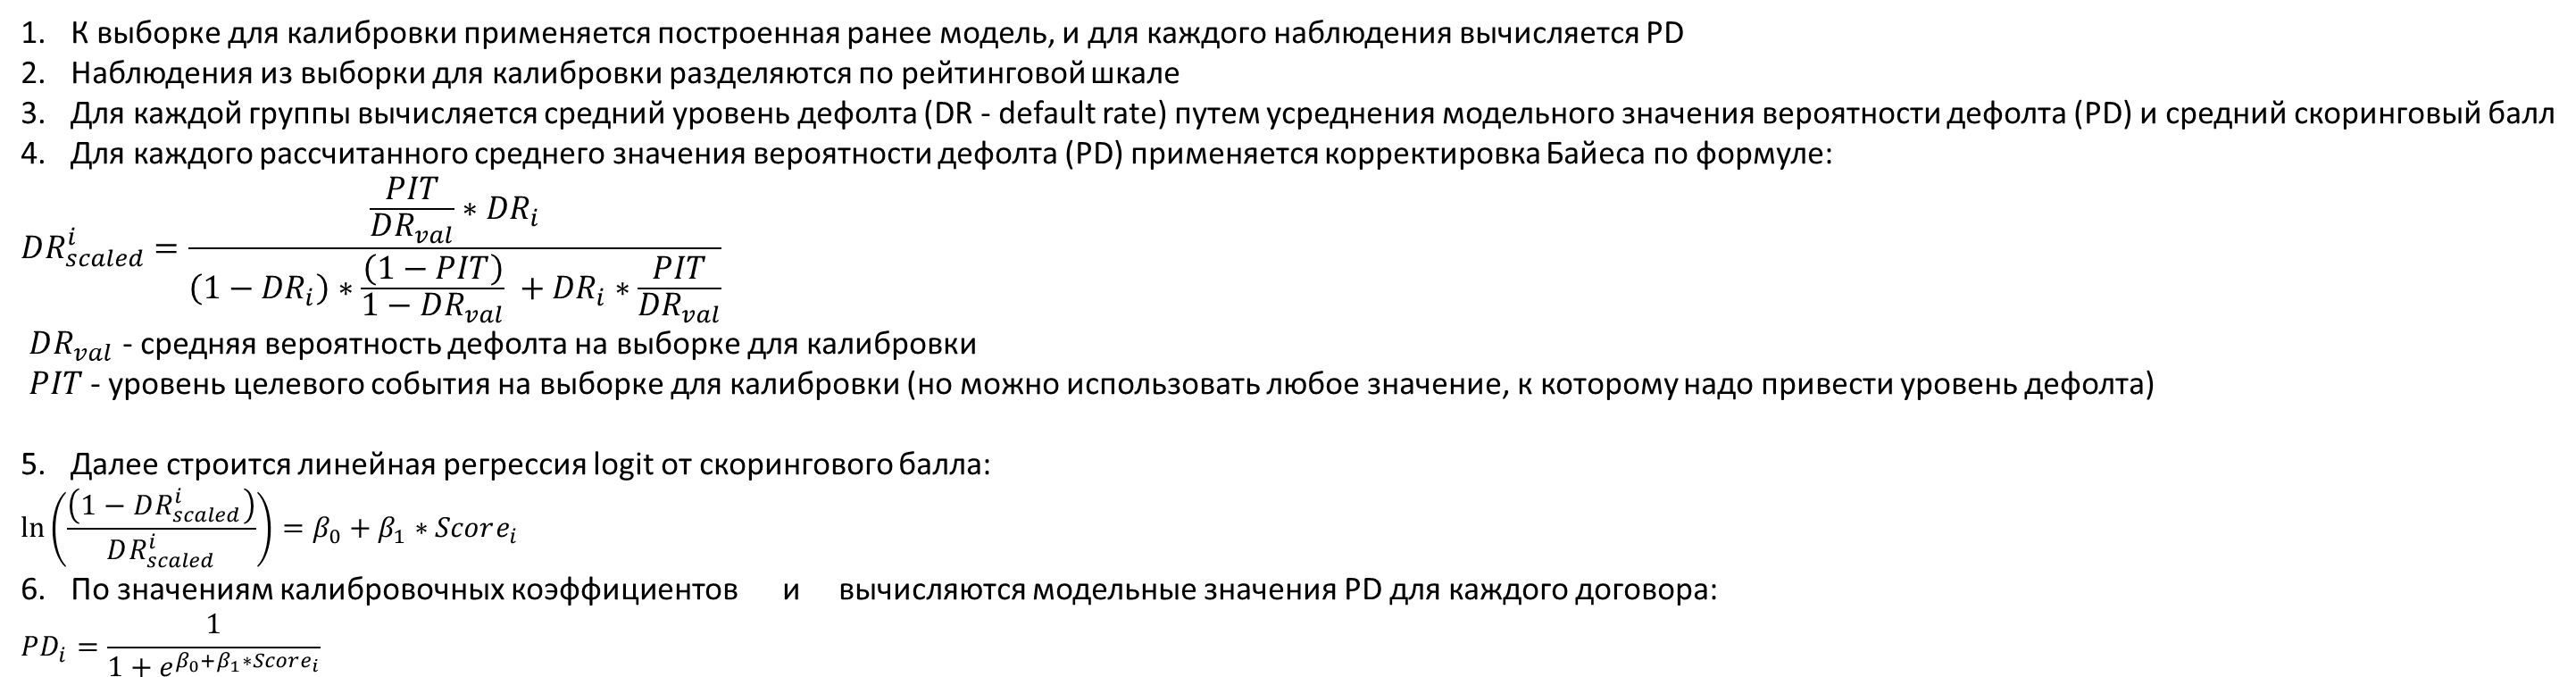

> –†–µ–∞–ª–∏–∑—É–π—Ç–µ —Ñ—É–Ω–∫—Ü–∏—é –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –ë–∞–π–µ—Å–æ–≤—Å–∫–æ–π –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏ –∏ –¥–æ–±–∞–≤–ª–µ–Ω–∏–µ –∫–∞–ª–∏–±—Ä–æ–≤–∞–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –∫ –¥–∞—Ç–∞—Å–µ—Ç—É.

> –ü—Ä–∏ —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ —Ñ—É–Ω–∫—Ü–∏–∏ —É—á—Ç–∏—Ç–µ —Å–ª–µ–¥—É—é—â–µ–µ:
* –ò–º—è —Å—Ç–æ–ª–±—Ü–∞ —Å –∫–∞–ª–∏–±—Ä–æ–≤–∞–Ω–Ω—ã–º –∑–Ω–∞—á–µ–Ω–∏–µ–º –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–µ—Ñ–æ–ª—Ç–∞ –¥–æ–ª–∂–Ω–æ –±—ã—Ç—å —Ä–∞–≤–Ω–æ –∑–Ω–∞—á–µ–Ω–∏—é –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π column_name
* –æ–∫—Ä—É–≥–ª–∏—Ç–µ –¥–æ 5-–≥–æ –∑–Ω–∞–∫–∞ –∑–Ω–∞—á–µ–Ω–∏—è PIT, DR_val –∏ –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã —Ä–µ–≥—Ä–µ—Å—Å–∏–∏

> –û–ø–∏—Å–∞–Ω–∏–µ —Ñ—É–Ω–∫—Ü–∏–∏:
* –ù–∞ –≤—Ö–æ–¥ –ø—Ä–∏–Ω–∏–º–∞–µ—Ç:
1. data_ - –¥–∞—Ç–∞—Å–µ—Ç —Å–æ –≤—Å–µ–º–∏ –ø–æ–ª—è–º–∏
2. master_scale_name - —Ç–∏–ø –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª—ã –ø–æ –∫–æ—Ç–æ—Ä–æ–π —Å—Ç—Ä–æ–∏–º –∫–∞–ª–∏–±—Ä–æ–≤–∫—É
3. calib_flg_name - –∏–º—è –∫–æ–ª–æ–Ω–∫–∏ —Å —Ñ–ª–∞–≥–æ–º –ø—Ä–∏–Ω–∞–¥–ª–µ–∂–Ω–æ—Å—Ç–∏ –Ω–∞–±–ª—é–¥–µ–Ω–∏—è –∫ –≤—ã–±–æ—Ä–∫–µ –¥–ª—è –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏
4. test_flg_name - –∏–º—è –∫–æ–ª–æ–Ω–∫–∏ —Å —Ñ–ª–∞–≥–æ–º –ø—Ä–∏–Ω–∞–¥–ª–µ–∂–Ω–æ—Å—Ç–∏ –Ω–∞–±–ª—é–¥–µ–Ω–∏—è –∫ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ
5. target_name - –∏–º—è —Ü–µ–ª–µ–≤–æ–≥–æ —Å–æ–±—ã—Ç–∏–µ
6. score_name - –∏–º—è —Å–∫–æ—Ä–∏–Ω–≥–æ–≤–æ–≥–æ –±–∞–ª–ª–∞
7. column_name - –∏–º—è –Ω–æ–≤–æ–≥–æ —Å—Ç–æ–ª–±—Ü–∞, –∫—É–¥–∞ –±—É–¥—É—Ç –∑–∞–ø–∏—Å–∞–Ω—ã –∫–∞–ª–∏–±—Ä–æ–≤–∞–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–µ—Ñ–æ–ª—Ç–∞
* –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç pandas.DataFrame —Å –∏–¥–µ–Ω—Ç–∏—á–Ω—ã–º–∏ –ø–æ–ª—è–º–∏, —á—Ç–æ –∏ –∏—Å—Ö–æ–¥–Ω—ã–π –¥–∞—Ç–∞—Ñ—Ä–µ–π–º + –¥–æ–ø–æ–ª–Ω—è–µ—Ç –∫–∞–ª–∏–±—Ä–æ–≤–∞–Ω–Ω—ã–º –∑–Ω–∞—á–µ–Ω–∏–µ–º column_name

In [16]:
def bayes_calibration(data_, master_scale_name, calib_flg_name, test_flg_name, target_name, score_name, column_name):
    calib_df = data_[data_[calib_flg_name] == 1]
    DR = calib_df.groupby(master_scale_name)['PD'].mean()
    Score = calib_df.groupby(master_scale_name)[score_name].mean()
    
    DR_val = round(calib_df['PD'].mean(), 5)
    PIT = round(calib_df['target'].mean(), 5)

    DR_scaled = PIT*DR/DR_val/((1-DR) * (1-PIT)/ (1-DR_val) + DR * PIT / DR_val)
    
    logit = LinearRegression().fit(np.reshape(Score.to_numpy(), (-1, 1)), np.log((1-DR_scaled)/DR_scaled))
    beta_0, beta_1 = round(logit.intercept_, 5) , round(logit.coef_[0], 5)
        
    data_[column_name] =  1/( 1 + np.exp(beta_0 + beta_1 * data_[score_name]))
        
    return data_
    

In [17]:
# –ü—Ä–æ–≤–µ—Ä—è–µ–º —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—é —Ñ—É–Ω–∫—Ü–∏–∏
# –ö–∞–ª–∏–±—Ä–æ–≤–∫–∞ –ø–æ –æ–±–æ–±—â–µ–Ω–Ω–æ–π –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª–µ
assert_data = bayes_calibration(data_ = assert_data.copy(), 
                                master_scale_name='MS_gen_PD', 
                                calib_flg_name='calib_flg',
                                test_flg_name='test_flg',
                                target_name='target',
                                score_name='SCORE',
                                column_name='PD_calib_bayes_gen')

# assert assert_data.shape == (600, 19)
assert 'PD_calib_bayes_gen' in assert_data.columns
assert round(assert_data['PD_calib_bayes_gen'].sum(), 5) == 333.33281

In [18]:
# –ü—Ä–æ–≤–µ—Ä—è–µ–º —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—é —Ñ—É–Ω–∫—Ü–∏–∏
# –ö–∞–ª–∏–±—Ä–æ–≤–∫–∞ –ø–æ –¥–µ—Ç–∞–ª–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–æ–π –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª–µ
assert_data = bayes_calibration(data_ = assert_data.copy(), 
                                master_scale_name='MS_det_PD', 
                                calib_flg_name='calib_flg',
                                test_flg_name='test_flg',
                                target_name='target',
                                score_name='SCORE',
                                column_name='PD_calib_bayes_det')

assert assert_data.shape == (600, 20)
assert 'PD_calib_bayes_det' in assert_data.columns
print(round(assert_data['PD_calib_bayes_det'].sum(), 5))
assert round(assert_data['PD_calib_bayes_det'].sum(), 5) == 328.33406

328.33406


In [19]:
%%time
# –ü—Ä–∏–º–µ–Ω—è–µ–º —Ñ—É–Ω–∫—Ü–∏—é –∫ —Ü–µ–ª–µ–≤–æ–π —Ç–∞–±–ª–∏—Ü–µ
# –ö–∞–ª–∏–±—Ä–æ–≤–∫–∞ –ø–æ –æ–±–æ–±—â–µ–Ω–Ω–æ–π –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª–µ
data = bayes_calibration(data_ = data.copy(), 
                         master_scale_name = 'MS_gen_PD', 
                         calib_flg_name = 'calib_flg',
                         test_flg_name = 'test_flg',
                         target_name = 'target',
                         score_name = 'SCORE',
                         column_name = 'PD_calib_bayes_gen'
                         )

# –ö–∞–ª–∏–±—Ä–æ–≤–∫–∞ –ø–æ –æ–±–æ–±—â–µ–Ω–Ω–æ–π –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª–µ
data = bayes_calibration(data_ = data.copy(), 
                         master_scale_name = 'MS_det_PD', 
                         calib_flg_name = 'calib_flg',
                         test_flg_name = 'test_flg',
                         target_name = 'target',
                         score_name = 'SCORE',
                         column_name = 'PD_calib_bayes_det'
                         )

Wall time: 466 ms


# Task 2. –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –¥–∏–∞–≥—Ä–∞–º–º –Ω–∞–¥–µ–∂–Ω–æ—Å—Ç–∏

> –†–µ–∞–ª–∏–∑—É–π—Ç–µ —Ñ—É–Ω–∫—Ü–∏—é –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è –¥–∏–∞–≥—Ä–∞–º–º –Ω–∞–¥–µ–∂–Ω–æ—Å—Ç–∏ –∏ –≤—ã—á–∏—Å–ª–µ–Ω–∏—è Brier score

> –ü—Ä–∏ —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ —Ñ—É–Ω–∫—Ü–∏–∏ —É—á—Ç–∏—Ç–µ —Å–ª–µ–¥—É—é—â–µ–µ:
* –í –∫–∞—á–µ—Å—Ç–≤–µ –ø—Ä–∏–º–µ—Ä–∞ –º–æ–∂–µ—Ç–µ –≤–æ—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è –ø—Ä–∏–º–µ—Ä–æ–º: https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

> –û–ø–∏—Å–∞–Ω–∏–µ —Ñ—É–Ω–∫—Ü–∏–∏:
* –ù–∞ –≤—Ö–æ–¥ –ø—Ä–∏–Ω–∏–º–∞–µ—Ç:
1. data_ - –¥–∞—Ç–∞—Å–µ—Ç —Å–æ –≤—Å–µ–º–∏ –ø–æ–ª—è–º–∏
2. prob_names_list - –∏–º–µ–Ω–∞ –∫–æ–ª–æ–Ω–æ–∫, —Å–æ–¥–µ—Ä–∂–∞—â–∏–µ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–µ—Ñ–æ–ª—Ç–∞, –∫–æ—Ç–æ—Ä—ã–µ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –æ—Ç–æ–±—Ä–∞–∑–∏—Ç—å –Ω–∞ –¥–∏–∞–≥—Ä–∞–º–º–µ
* –û—Ç–æ–±—Ä–∞–∂–∞–µ—Ç –¥–∏–∞–≥—Ä–∞–º–º—É –Ω–∞–¥–µ–∂–Ω–æ—Å—Ç–∏, –∞–Ω–∞–ª–æ–≥–∏—á–Ω—É—é –ø—Ä–∏–º–µ—Ä—É
* –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Å–ø–∏—Å–æ–∫ Brier score –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Ü–µ–ª–µ–≤–æ–≥–æ —Å–æ–±—ã—Ç–∏—è




In [20]:
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ—Ç—Ä–∏—Å–æ–≤–∫–∏ –¥–∏–∞–≥—Ä–∞–º–º –Ω–∞–¥–µ–∂–Ω–æ—Å—Ç–∏

def plot_calibration_curve(data_, prob_names_list):
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(5, 2)
    colors = plt.cm.get_cmap("Dark2")

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    calibration_displays = {}
    for i, col in enumerate(prob_names_list[:]):
        display = CalibrationDisplay.from_predictions(
            data_['target'],
            data_[col],
            n_bins=10,
            name=col,
            ax=ax_calibration_curve,
            color=colors(i),
        )
        
        calibration_displays[col] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

    # Add histogram
    grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4,0)]
    for i, col in enumerate(prob_names_list):
        row, col_0 = grid_positions[i]
        ax = fig.add_subplot(gs[row, col_0])

        ax.hist(
            data_[col],
            range=(0, 1),
            bins=10,
            label=col,
            color=colors(i),
        )
        ax.set(title=col, xlabel="Mean predicted probability", ylabel="Count")

    plt.tight_layout()
    plt.show()
    
    return [brier_score_loss(data_['target'], data_[col]) for col in prob_names_list]
    

In [21]:
# –ü—Ä–æ–≤–µ—Ä—è–µ–º —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—é —Ñ—É–Ω–∫—Ü–∏–∏
assert_brier_score_list = plot_calibration_curve(data_ = assert_data[assert_data['calib_flg']==1].copy(),
                                          prob_names_list = ['PD', 
                                                             'PD_calib_platt',
                                                             'PD_calib_isoton', 
                                                             'PD_calib_bayes_gen',
                                                             'PD_calib_bayes_det'
                                                             ]
                                          )
clear_output()
print(round(np.sum(assert_brier_score_list), 5))
assert round(np.sum(assert_brier_score_list), 5) == 1.19124

1.19124


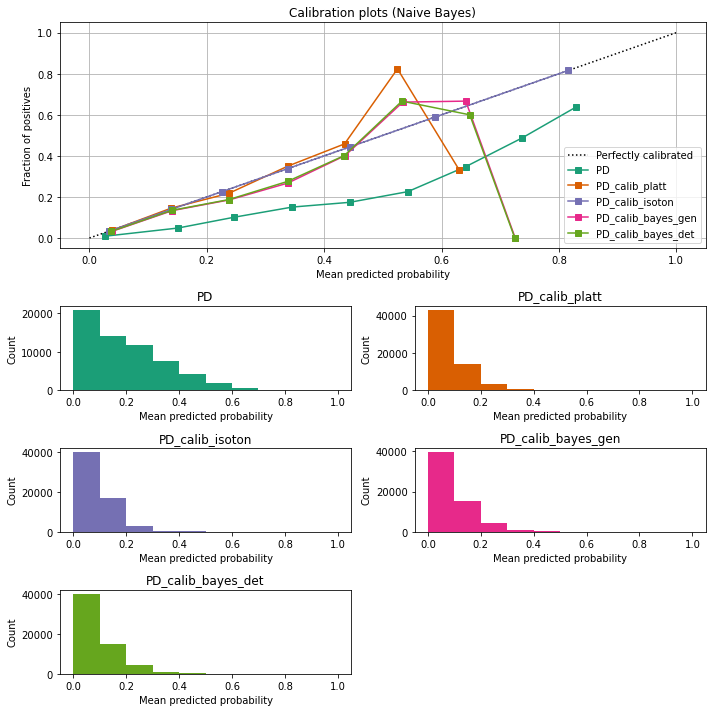

In [22]:
# –ü—Ä–∏–º–µ–Ω—è–µ–º —Ñ—É–Ω–∫—Ü–∏—é –∫ —Ü–µ–ª–µ–≤–æ–π —Ç–∞–±–ª–∏—Ü–µ
brier_score_list = plot_calibration_curve(data_=data[data['calib_flg']==1].copy(),
                                          prob_names_list = ['PD', 
                                                             'PD_calib_platt',
                                                             'PD_calib_isoton', 
                                                             'PD_calib_bayes_gen',
                                                             'PD_calib_bayes_det'
                                                             ]
                                          )

# Task 3. –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –ø–æ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª–µ

> –†–µ–∞–ª–∏–∑—É–π—Ç–µ —Ñ—É–Ω–∫—Ü–∏—é –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–µ—Ñ–æ–ª—Ç–∞ –ø–æ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª–µ.

> –ü—Ä–∏ —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ —Ñ—É–Ω–∫—Ü–∏–∏ —É—á—Ç–∏—Ç–µ —Å–ª–µ–¥—É—é—â–µ–µ:

> –û–ø–∏—Å–∞–Ω–∏–µ —Ñ—É–Ω–∫—Ü–∏–∏:
* –ù–∞ –≤—Ö–æ–¥ –ø—Ä–∏–Ω–∏–º–∞–µ—Ç:
1. data_ - –¥–∞—Ç–∞—Å–µ—Ç —Å–æ –≤—Å–µ–º–∏ –ø–æ–ª—è–º–∏
2. test_flg_name - —Ñ–ª–∞–≥ –ø—Ä–∏–Ω–∞–¥–ª–µ–∂–Ω–æ—Å—Ç–∏ –Ω–∞–±–ª—é–¥–µ–Ω–∏—è –∫ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ 
3. pd_name - –∏–º—è —Å—Ç–æ–ª–±—Ü–∞ —Å –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é –¥–µ—Ñ–æ–ª—Ç–∞
4. target_name - –∏–º—è —Ü–µ–ª–µ–≤–æ–≥–æ —Å–æ–±—ã—Ç–∏—è
5. master_scale_type - —Ç–∏–ø –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª—ã (–º–æ–∂–µ—Ç –±—ã—Ç—å 'generalized' - –æ–±–æ–±—â–µ–Ω–Ω–æ–π –∏ 'detailed' - –¥–µ—Ç–∞–ª–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–æ–π)
* –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Å–ø–∏—Å–æ–∫ –∏–∑ –¥–≤—É—Ö pandas.DataFrame: –ø–µ—Ä–≤—ã–π —ç–ª–µ–º–µ–Ω—Ç —Å–ø–∏—Å–∫–∞ —Å—Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω –¥–ª—è train –≤—ã–±–æ—Ä–∫–∏, –≤—Ç–æ—Ä–æ–π —ç–ª–µ–º–µ–Ω—Ç —Å–ø–∏—Å–∫–∞ —Å—Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω –¥–ª—è test –≤—ã–±–æ—Ä–∫–∏
* pandas.DataFrame —Å–æ–¥–µ—Ä–∂–∞—Ç —Å–ª–µ–¥—É—é—â–∏–µ —Å—Ç–æ–ª–±—Ü—ã:
1. MASTER_SCALE - –Ω–∞–∑–≤–∞–Ω–∏—è –±–∏–Ω–æ–≤ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª—ã	
2. pd_name (–ø–∞—Ä–∞–º–µ—Ç—Ä —Ñ—É–Ω–∫—Ü–∏–∏) - —Å—Ä–µ–¥–Ω–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ —Å—Ç–æ–ª–±—Ü–∞ pd_name –¥–ª—è —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–≥–æ –±–∏–Ω–∞ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª—ã
3. target - —Å—Ä–µ–¥–Ω–µ–µ —É—Ä–æ–≤–µ–Ω—å –¥–µ—Ñ–æ–ª—Ç–∞ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π –≤ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–º –±–∏–Ω–µ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª—ã

In [23]:
# –§—É–Ω–∫—Ü–∏—è –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–π –ø–æ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª–µ
def plot_master_distribution(data_, test_flg_name, pd_name, target_name, master_scale_type):
    master_func = f_master_gen if master_scale_type == 'generalized' else f_master_det
    train = data_[data_[test_flg_name] == 0]
    test  = data_[data_[test_flg_name] == 1]
    
    res = []
    for df in [train, test]:
        df['MASTER_SCALE'] = df[pd_name].apply(master_func)
        p = df.groupby('MASTER_SCALE')[[pd_name, target_name]].mean()
        p = p.reset_index()
        res.append(p)
    return res

    

In [24]:
# –ü—Ä–æ–≤–µ—Ä—è–µ–º —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—é —Ñ—É–Ω–∫—Ü–∏–∏
assert_df_list = []
pd_name_list = ['PD', 
                'PD_calib_platt',
                'PD_calib_isoton', 
                'PD_calib_bayes_gen',
                'PD_calib_bayes_det'
                ]
for pd_name in pd_name_list:
    for ms_type in ['generalized', 'detailed']:
        assert_df_list.append(plot_master_distribution(data_ = assert_data.copy(), 
                                                       test_flg_name = 'test_flg',
                                                       pd_name = pd_name,
                                                       target_name = 'target',
                                                       master_scale_type = ms_type
                                                       )
        )

res = 0
for i, ls in enumerate(assert_df_list):
    for j, d in enumerate(ls):
        res += assert_df_list[i][j]['target'].sum()
assert round(res, 5) == 13.32501

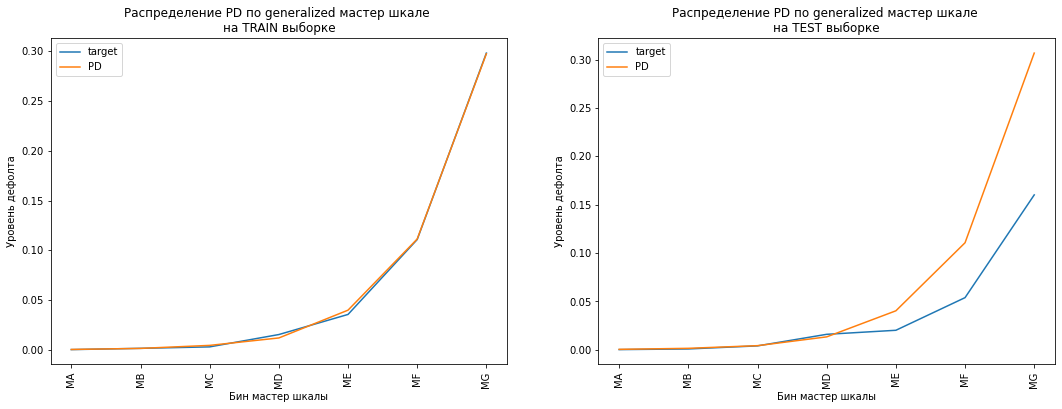

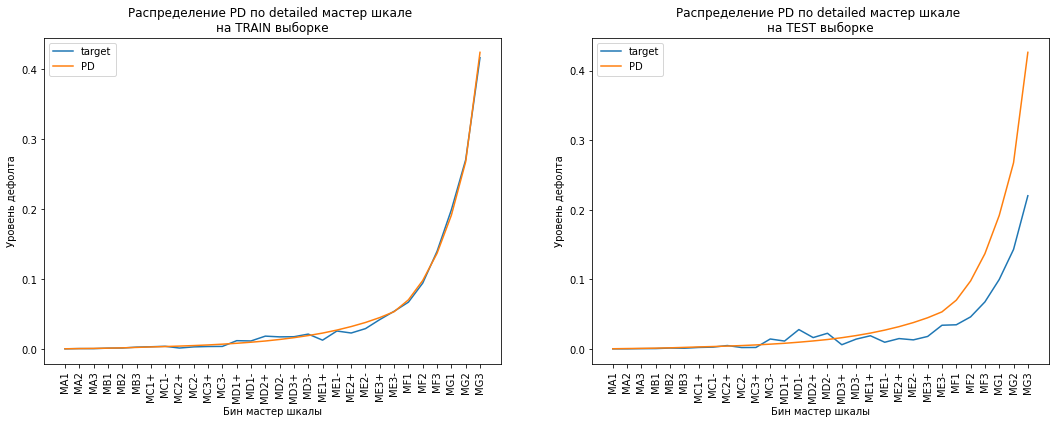

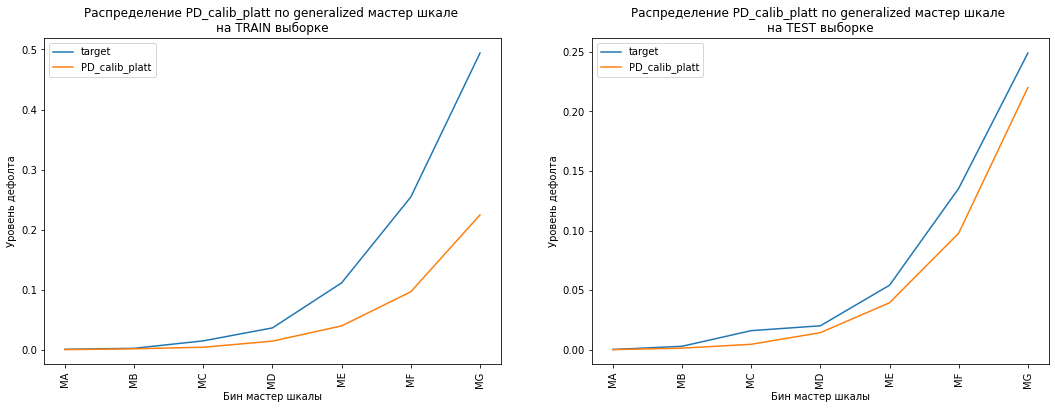

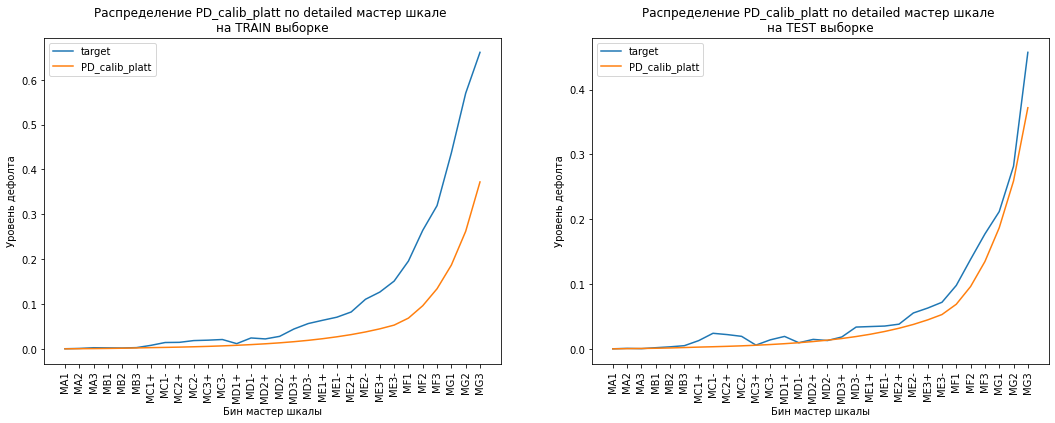

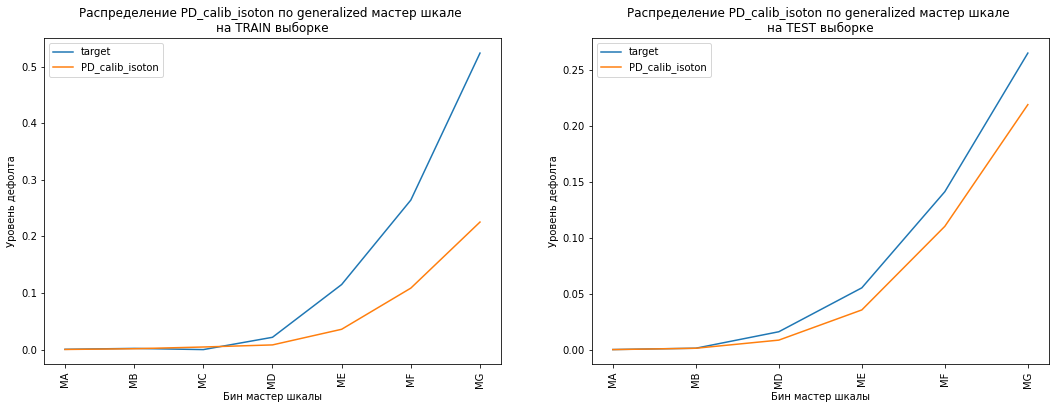

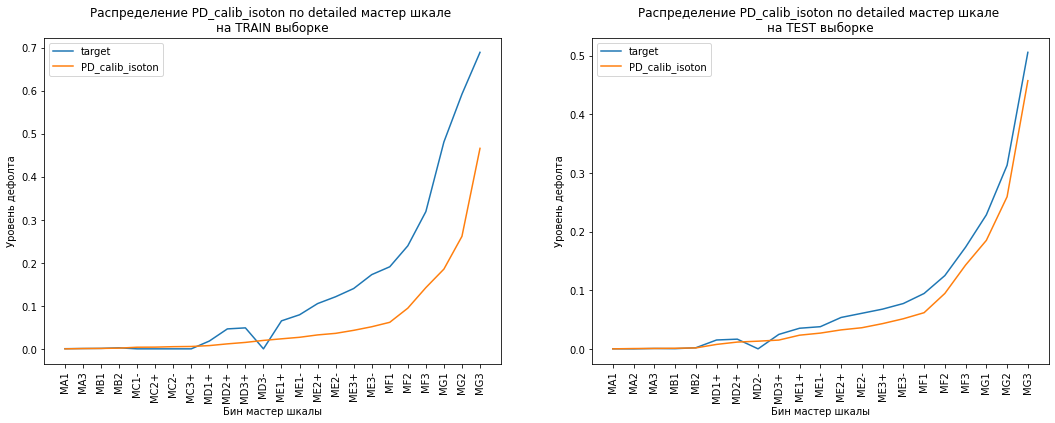

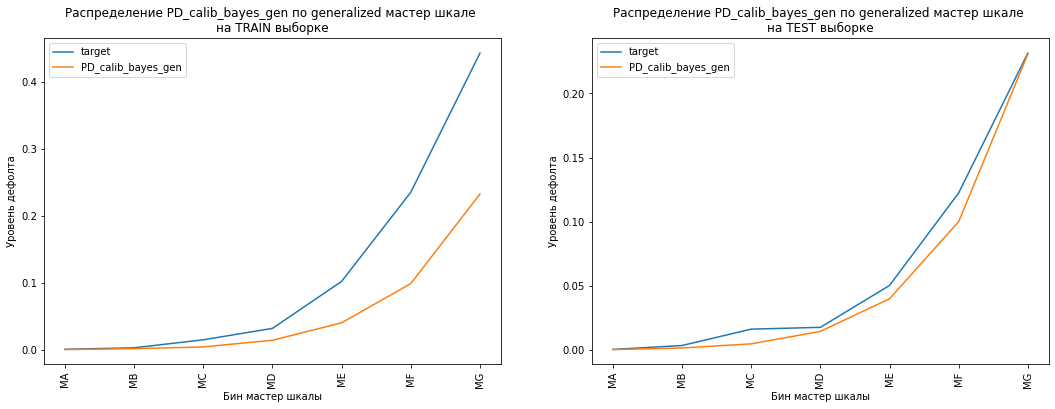

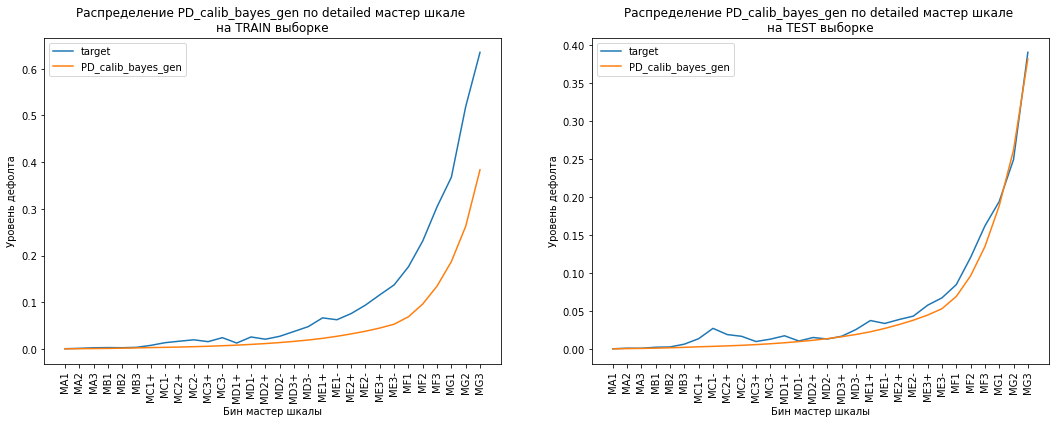

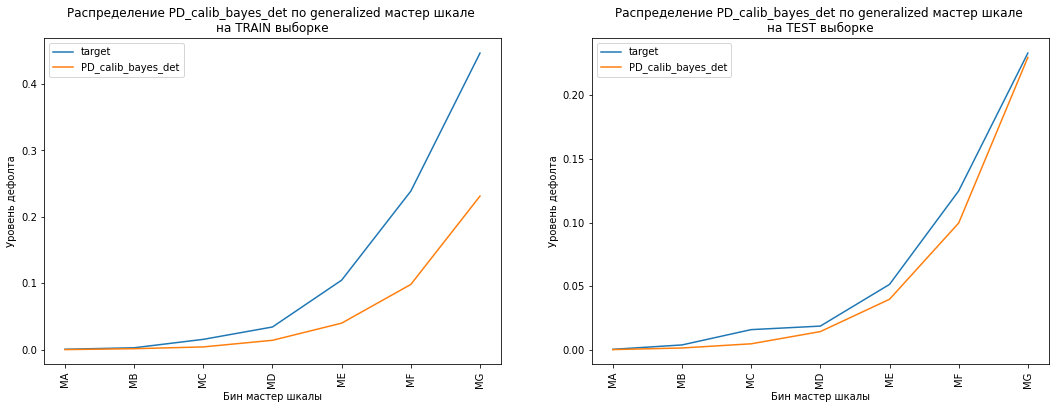

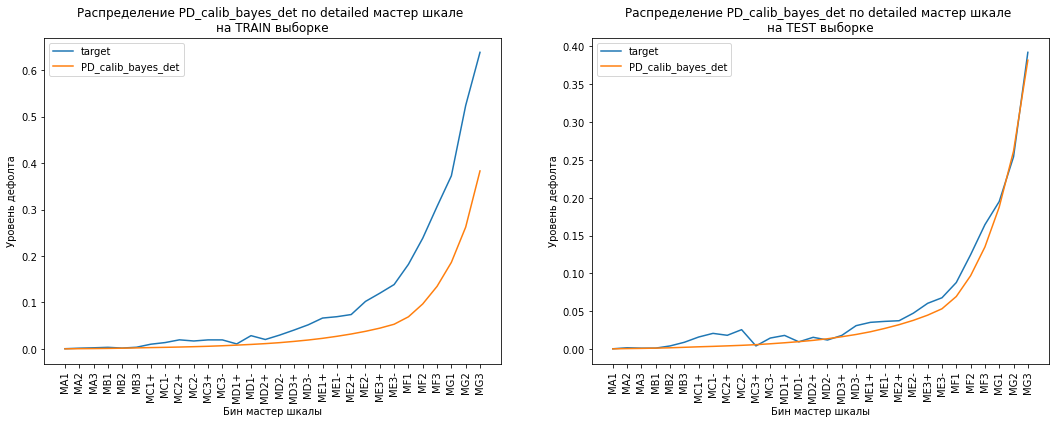

In [25]:
# –ü—Ä–∏–º–µ–Ω—è–µ–º —Ñ—É–Ω–∫—Ü–∏—é –∫ —Ü–µ–ª–µ–≤–æ–π —Ç–∞–±–ª–∏—Ü–µ
pd_name_list = ['PD', 
                'PD_calib_platt',
                'PD_calib_isoton', 
                'PD_calib_bayes_gen',
                'PD_calib_bayes_det'
                ]
for pd_name in pd_name_list:
    for ms_type in ['generalized', 'detailed']:
        df_list = plot_master_distribution(data_ = data.copy(), 
                                            test_flg_name = 'test_flg',
                                            pd_name = pd_name,
                                            target_name = 'target',
                                            master_scale_type = ms_type
                                            )
        fig, ax = plt.subplots(1, 2, figsize=(18,6))
        df_name_list = ['TRAIN', 'TEST']
        for i, df in enumerate(df_list):
            
            ax[i].set_title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ {pd_name} –ø–æ {ms_type} –º–∞—Å—Ç–µ—Ä —à–∫–∞–ª–µ \n–Ω–∞ {df_name_list[i]} –≤—ã–±–æ—Ä–∫–µ')
            ax[i].set_xlabel('–ë–∏–Ω –º–∞—Å—Ç–µ—Ä —à–∫–∞–ª—ã')
            ax[i].set_ylabel('–£—Ä–æ–≤–µ–Ω—å –¥–µ—Ñ–æ–ª—Ç–∞')
            ax[i].tick_params(axis='x', rotation=90)

            ax[i].plot(df['MASTER_SCALE'], df['target'], label='target', linestyle ='-')
            ax[i].plot(df['MASTER_SCALE'], df[pd_name], label=pd_name, linestyle ='-')
            ax[i].legend()

        plt.show()

# Task 4. –ë–∏–Ω–æ–º–∏–∞–ª—å–Ω—ã–π —Ç–µ—Å—Ç

–ò–¥–µ—è —Ç–µ—Å—Ç–∞ –∑–∞–∫–ª—é—á–∞–µ—Ç—Å—è –≤ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–∏ –∫—Ä–∏—Ç–∏—á–µ—Å–∫–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏—è —á–∏—Å–ª–∞ –¥–µ—Ñ–æ–ª—Ç–æ–≤ –∏–ª–∏ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–µ—Ñ–æ–ª—Ç–∞ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Ä–µ–π—Ç–∏–Ω–≥–æ–≤–æ–≥–æ –∫–ª–∞—Å—Å–∞ –∏ —Å—Ä–∞–≤–Ω–µ–Ω–∏—è —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏—Ö –∑–Ω–∞—á–µ–Ω–∏–π —Å –∫—Ä–∏—Ç–∏—á–µ—Å–∫–∏–º–∏.

–í —Ä–∞–º–∫–∞—Ö –¥–∞–Ω–Ω–æ–≥–æ —Ç–µ—Å—Ç–∞ –≤—ã–¥–≤–∏–≥–∞—é—Ç—Å—è —Å–ª–µ–¥—É—é—â–∏–µ –≥–∏–ø–æ—Ç–µ–∑—ã:
H0 - –≤—Å–µ –æ—Ü–µ–Ω–∫–∏ PD, –ø–æ–ª—É—á–µ–Ω–Ω—ã–µ –ø—Ä–∏ –ø–æ–º–æ—â–∏ –º–æ–¥–µ–ª–∏, –∫–æ—Ä—Ä–µ–∫—Ç–Ω—ã
H1 - —Ö–æ—Ç—è –±—ã –æ–¥–Ω–∞ –æ—Ü–µ–Ω–∫–∞ PD –Ω–µ–∫–æ—Ä—Ä–µ–∫—Ç–Ω–∞

–†–∞—Å—á–µ—Ç –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã—Ö –∏–Ω—Ç–µ—Ä–≤–∞–ª–æ–≤:
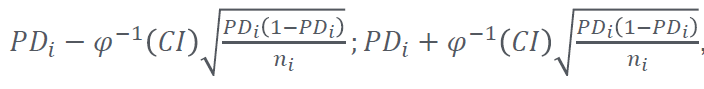

* 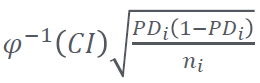 - –∫—Ä–∏—Ç–∏—á–µ—Å–∫–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ —É—Ä–æ–≤–Ω—è –¥–µ—Ñ–æ–ª—Ç–æ–≤, –∞–ø–ø—Ä–æ–∫—Å–∏–º–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ —Å –ø–æ–º–æ—â—å—é
–Ω–æ—Ä–º–∞–ª—å–Ω–æ–≥–æ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è
* 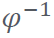 - –æ–±—Ä–∞—Ç–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è –Ω–æ—Ä–º–∞–ª—å–Ω–æ–≥–æ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è,
* ùê∂ùêº - —É—Ä–æ–≤–µ–Ω—å –¥–æ–≤–µ—Ä–∏—è,
* ùëÉùê∑ùëñ - –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –¥–µ—Ñ–æ–ª—Ç–∞ –≤ i –æ–º —Å–∫–æ—Ä–∏–Ω–≥–æ–≤–æ–º –∫–ª–∞—Å—Å–µ.

> –†–µ–∞–ª–∏–∑—É–π—Ç–µ —Ñ—É–Ω–∫—Ü–∏—é –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏ –±–∏–Ω–æ–º–∏–∞–ª—å–Ω–æ–≥–æ —Ç–µ—Å—Ç–∞.

> –ü—Ä–∏ —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ —Ñ—É–Ω–∫—Ü–∏–∏ —É—á—Ç–∏—Ç–µ —Å–ª–µ–¥—É—é—â–µ–µ:
* –≤–æ—Å–ø–æ–ª—å–∑—É–π—Ç–µ—Å—å —Ñ—É–Ω–∫—Ü–∏–µ–π norm.ppf(CI)

> –û–ø–∏—Å–∞–Ω–∏–µ —Ñ—É–Ω–∫—Ü–∏–∏:
* –ù–∞ –≤—Ö–æ–¥ –ø—Ä–∏–Ω–∏–º–∞–µ—Ç:
1. data_ - –¥–∞—Ç–∞—Å–µ—Ç —Å–æ –≤—Å–µ–º–∏ –ø–æ–ª—è–º–∏
2. pd_name - –∏–º—è —Å—Ç–æ–ª–±—Ü–∞ —Å –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é –¥–µ—Ñ–æ–ª—Ç–∞
3. target_name - –∏–º—è —Ü–µ–ª–µ–≤–æ–≥–æ —Å–æ–±—ã—Ç–∏—è
4. master_scale_type - —Ç–∏–ø –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª—ã (–º–æ–∂–µ—Ç –±—ã—Ç—å 'generalized' - –æ–±–æ–±—â–µ–Ω–Ω–æ–π –∏ 'detailed' - –¥–µ—Ç–∞–ª–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–æ–π)
5. a_CI_for_binominal_test - –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω—ã–π –∏–Ω—Ç–µ—Ä–≤–∞–ª
* –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç pandas.DataFrame —Å–æ —Å–ª–µ–¥—É—é—â–∏–º–∏ —Å—Ç–æ–ª–±—Ü–∞–º–∏:
1. MASTER_SCALE - –Ω–∞–∑–≤–∞–Ω–∏—è –±–∏–Ω–æ–≤ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª—ã	
2. pd_name (–ø–∞—Ä–∞–º–µ—Ç—Ä —Ñ—É–Ω–∫—Ü–∏–∏) - —Å—Ä–µ–¥–Ω–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ —Å—Ç–æ–ª–±—Ü–∞ pd_name –¥–ª—è —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–≥–æ –±–∏–Ω–∞ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª—ã
3. target - —Å—Ä–µ–¥–Ω–µ–µ —É—Ä–æ–≤–µ–Ω—å –¥–µ—Ñ–æ–ª—Ç–∞ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π –≤ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–º –±–∏–Ω–µ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª—ã
4. cnt - –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–∞–±–ª—é–¥–µ–Ω–∏–π –≤ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–º –±–∏–Ω–µ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª—ã
5. CI_LEFT - –ª–µ–≤–∞—è –≥—Ä–∞–Ω–∏—Ü–∞ –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω–æ–≥–æ –∏–Ω—Ç–µ—Ä–≤–∞–ª–∞ –¥–ª—è —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–≥–æ –±–∏–Ω–∞ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª—ã
6. CI_RIGHT - –ø—Ä–∞–≤–∞—è –≥—Ä–∞–Ω–∏—Ü–∞ –¥–æ–≤–µ—Ä–∏—Ç–µ–ª—å–Ω–æ–≥–æ –∏–Ω—Ç–µ—Ä–≤–∞–ª–∞ –¥–ª—è —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–≥–æ –±–∏–Ω–∞ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª—ã
7. conclusion - –∑–∞–∫–ª—é—á–µ–Ω–∏–µ –æ –ø—Ä–æ—Ö–æ–∂–¥–µ–Ω–∏–∏ —Ç–µ—Å—Ç–∞: '—Ç–µ—Å—Ç –ø—Ä–æ–π–¥–µ–Ω' –∏–ª–∏ '—Ç–µ—Å—Ç –Ω–µ –ø—Ä–æ–π–¥–µ–Ω'

In [26]:
def binomial_test(data_, pd_name, target_name, master_scale_type, a_CI_for_binominal_test):
    master_func = f_master_gen if master_scale_type == 'generalized' else f_master_det
    
    data_['MASTER_SCALE'] = data_[pd_name].apply(master_func)
    df = data_.groupby('MASTER_SCALE')[[pd_name, target_name]].mean()
    df['cnt'] = data_.groupby('MASTER_SCALE')[pd_name].size()
    
    df['CI_LEFT'] = df[pd_name] - norm.ppf(a_CI_for_binominal_test) * np.sqrt(df[pd_name] * (1-df[pd_name])/df['cnt'])
    df['CI_RIGHT'] = df[pd_name] + norm.ppf(a_CI_for_binominal_test) * np.sqrt(df[pd_name] * (1-df[pd_name])/df['cnt'])
        
    
    df['conclusion'] = df.apply(lambda x: '—Ç–µ—Å—Ç –ø—Ä–æ–π–¥–µ–Ω' if x[target_name] <= x['CI_RIGHT'] and x[target_name] >= x['CI_LEFT'] else '—Ç–µ—Å—Ç –Ω–µ –ø—Ä–æ–π–¥–µ–Ω', axis=1 )    
    df= df.reset_index()
    return df
    

In [27]:
# –ü—Ä–æ–≤–µ—Ä—è–µ–º —Ä–µ–∞–ª–∏–∑–∞—Ü–∏—é —Ñ—É–Ω–∫—Ü–∏–∏
assert_df_list = []
pd_name_list = ['PD', 
                'PD_calib_platt',
                'PD_calib_isoton', 
                'PD_calib_bayes_gen',
                'PD_calib_bayes_det'
                ]
for pd_name in pd_name_list:
    for i, ms_type in enumerate(['generalized', 'detailed']):
        assert_df_list.append(binomial_test(data_ = assert_data[assert_data['calib_flg']==1].copy(), 
                              pd_name = pd_name,
                              target_name = 'target',
                              master_scale_type = ms_type,
                              a_CI_for_binominal_test = 0.99
                              ))
        
res_tar = 0
res_ci_left = 0
res_ci_right = 0
for i, d in enumerate(assert_df_list):
    res_tar += assert_df_list[i]['target'].sum()
    res_ci_left += assert_df_list[i]['CI_LEFT'].sum()
    res_ci_right += assert_df_list[i]['CI_RIGHT'].sum()
assert round(res_tar, 5) == 6.47692
assert round(res_ci_left, 5) == 4.25204
assert round(res_ci_right, 5) == 8.54361

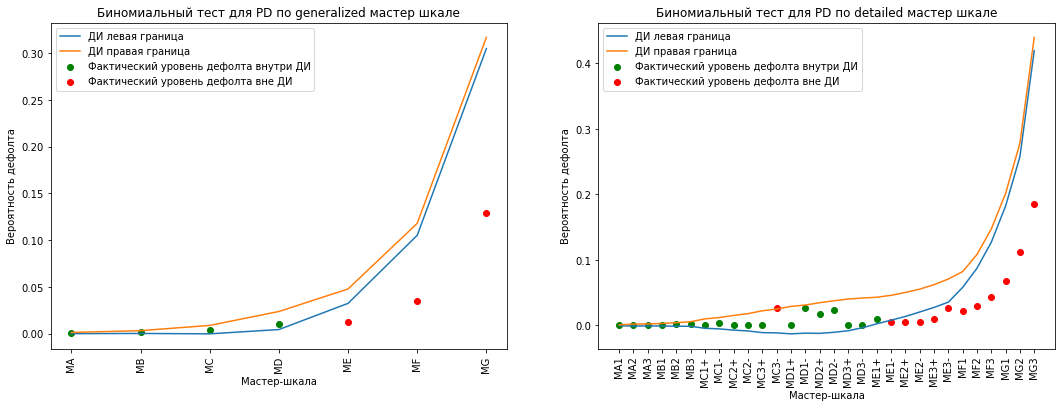

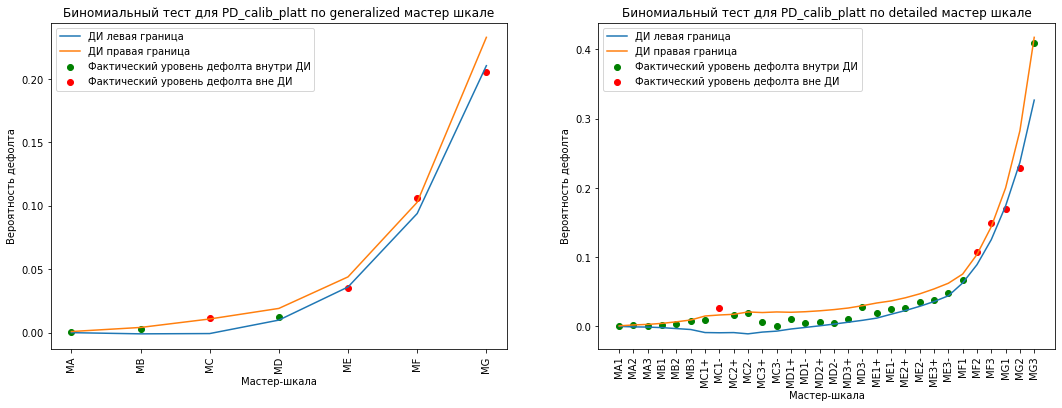

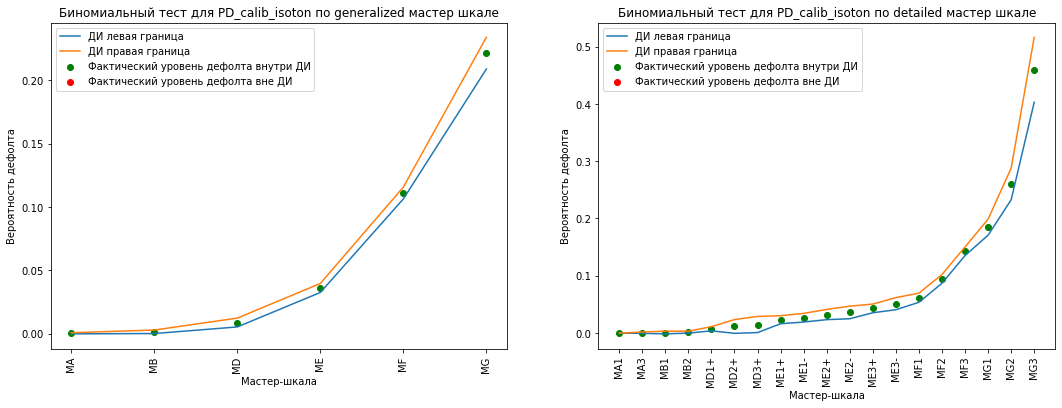

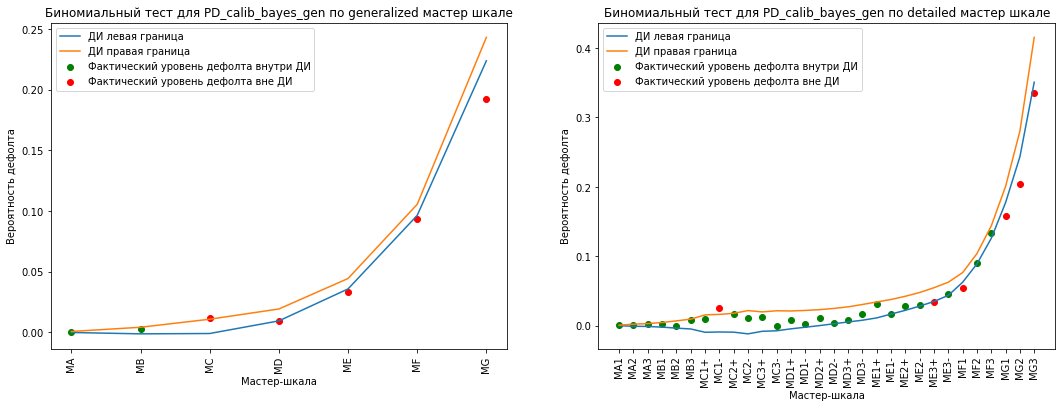

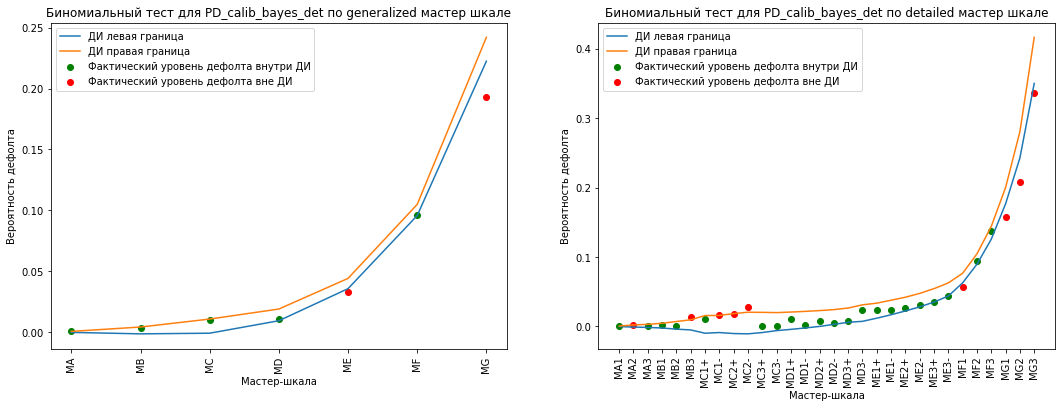

In [28]:
# –ü—Ä–∏–º–µ–Ω—è–µ–º —Ñ—É–Ω–∫—Ü–∏—é –∫ —Ü–µ–ª–µ–≤–æ–π —Ç–∞–±–ª–∏—Ü–µ
pd_name_list = ['PD', 
                'PD_calib_platt',
                'PD_calib_isoton', 
                'PD_calib_bayes_gen',
                'PD_calib_bayes_det'
                ]
for pd_name in pd_name_list:
    fig, ax = plt.subplots(1, 2, figsize=(18,6))
    for i, ms_type in enumerate(['generalized', 'detailed']):
        df = binomial_test(data_ = data[data['calib_flg']==1].copy(), 
                           pd_name = pd_name,
                           target_name = 'target',
                           master_scale_type = ms_type,
                           a_CI_for_binominal_test = 0.99
                           )
        
        # –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
        ax[i].set_title(f'–ë–∏–Ω–æ–º–∏–∞–ª—å–Ω—ã–π —Ç–µ—Å—Ç –¥–ª—è {pd_name} –ø–æ {ms_type} –º–∞—Å—Ç–µ—Ä —à–∫–∞–ª–µ')
        ax[i].set_xlabel('–ú–∞—Å—Ç–µ—Ä-—à–∫–∞–ª–∞')
        ax[i].set_ylabel('–í–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –¥–µ—Ñ–æ–ª—Ç–∞')
        ax[i].tick_params(axis='x', rotation=90)
        
        ax[i].plot(df['MASTER_SCALE'], df['CI_LEFT'], label='–î–ò –ª–µ–≤–∞—è –≥—Ä–∞–Ω–∏—Ü–∞')
        ax[i].plot(df['MASTER_SCALE'], df['CI_RIGHT'], label='–î–ò –ø—Ä–∞–≤–∞—è –≥—Ä–∞–Ω–∏—Ü–∞')
        ax[i].scatter(df[df['conclusion']=='—Ç–µ—Å—Ç –ø—Ä–æ–π–¥–µ–Ω']['MASTER_SCALE'], 
                df[df['conclusion']=='—Ç–µ—Å—Ç –ø—Ä–æ–π–¥–µ–Ω']['target'], 
                label='–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–π —É—Ä–æ–≤–µ–Ω—å –¥–µ—Ñ–æ–ª—Ç–∞ –≤–Ω—É—Ç—Ä–∏ –î–ò',
                color = 'green'
                )
        ax[i].scatter(df[df['conclusion']=='—Ç–µ—Å—Ç –Ω–µ –ø—Ä–æ–π–¥–µ–Ω']['MASTER_SCALE'], 
                df[df['conclusion']=='—Ç–µ—Å—Ç –Ω–µ –ø—Ä–æ–π–¥–µ–Ω']['target'], 
                label='–§–∞–∫—Ç–∏—á–µ—Å–∫–∏–π —É—Ä–æ–≤–µ–Ω—å –¥–µ—Ñ–æ–ª—Ç–∞ –≤–Ω–µ –î–ò',
                color = 'red'
                )
        ax[i].legend()

    plt.show()

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤

–í—ã–±–µ—Ä–µ—Ç–µ —Å–ø–æ—Å–æ–± –ø—Ä–µ–¥–ø–æ—á–∏—Ç–∞–µ–º–æ–π –∫–∞–ª–∏–±—Ä–æ–≤–∫–∏, –æ–±—ä—è—Å–Ω–∏—Ç–µ —Å–≤–æ–π –≤—ã–±–æ—Ä.

–°–æ—Ö—Ä–∞–Ω–∏—Ç–µ –≤—ã–±—Ä–∞–Ω–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –∫–∞–ª–∏–±—Ä–æ–≤–∞–Ω–Ω–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏—è PD –≤ —Ç–∞–±–ª–∏—Ü—É —Å –Ω–∞–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ–º –ø–æ–ª—è "PD_calib".

–¢–∞–∫–∂–µ –ø—Ä–æ—Å—Ç–∞–≤–∏–º –±–∞–∫–µ—Ç –ø–æ –º–∞—Å—Ç–µ—Ä-—à–∫–∞–ª–µ –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç –∑–Ω–∞—á–µ–Ω–∏—è PD_calib.

In [29]:
data['PD_calib'] = data['PD_calib_isoton']
data['MS_gen_PD_calib'] = f_master_gen(data['PD_calib'])
data['MS_det_PD_calib'] = f_master_det(data['PD_calib'])

In [30]:
data.to_csv('./data_grp_woe_pd_score_calib.csv', index=False)